# Objetivos

*  Desarrollar un nuevo enfoque de pronóstico para mejorar la precisión de las predicciones de ventas de productos de DSMarket.
*  Actualmente dependen de enfoques rudimentarios.
*  Empezar pronosticando las ventas a nivel de **tienda-producto**, y obtener las **ventas agregadas por departamento/tienda/ciudad** sumando los pronósticos independientes. Evaluar si este sigue siendo un enfoque válido.

*  Comenzar con **pronósticos de 28 días** (4 semanas) como prueba inicial.
Para un problema de pronóstico de ventas como este, recomendaría utilizar una serie temporal sobre un **modelo de regresión**, por las siguientes razones:
Los datos de ventas tienen una fuerte componente temporal seriada - las ventas en un día o semana están altamente correlacionadas con las ventas en periodos recientes. Un modelo de serie temporal captura mejor esta autocorrelación.
* No tenemos variables independientes obvias para hacer una regresión (como precios, promociones, etc). El enfoque sería un modelo de serie temporal univariado usando solo los datos históricos de ventas.
* Podemos incorporar estacionalidad, tendencias y otros patrones temporales en el modelo de serie temporal. Esto es difícil de capturar en un modelo de regresión simple.
* Podemos utilizar técnicas sofisticadas como RNN, **LSTM y redes neuronales** en los modelos de serie temporal para capturar relaciones no lineales en los datos.
* Los modelos de serie temporal son más adecuados cuando nuestro interés principal es la predicción, mientras que la regresión se enfoca más en inferir relaciones entre variables.

# Librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Cargar datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_sales = pd.read_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/Base_datos/item_sales.csv')
df_prices = pd.read_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/Base_datos/item_prices.csv')
df_calendar = pd.read_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/Base_datos/daily_calendar_with_events.csv')

# EDA


In [4]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    cantidad_filas_duplicadas = df.duplicated().sum()
    print()
    print("Cantidad total de filas duplicadas:", cantidad_filas_duplicadas)
    print(f"Tenemos un total de {total_nulos} nulos")

## EDA Sales Table

In [5]:
report_df(df_sales.iloc[:,:10])
df_sales.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          30490 non-null  object
 1   item        30490 non-null  object
 2   category    30490 non-null  object
 3   department  30490 non-null  object
 4   store       30490 non-null  object
 5   store_code  30490 non-null  object
 6   region      30490 non-null  object
 7   d_1         30490 non-null  int64 
 8   d_2         30490 non-null  int64 
 9   d_3         30490 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.3+ MB
None

Cantidad total de filas duplicadas: 0
Tenemos un total de 0 nulos


,id,item,category,department,store,store_code,region,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676

## EDA Calendar Table

In [6]:
report_df(df_calendar)
df_calendar.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB
None

Cantidad total de filas duplicadas: 0
Tenemos un total de 1887 nulos


,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN


## EDA Prices Table


In [7]:
report_df(df_prices)
df_prices.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965706 entries, 0 to 6965705
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    float64
 4   sell_price  float64
dtypes: float64(2), object(3)
memory usage: 265.7+ MB
None

Cantidad total de filas duplicadas: 212120
Tenemos un total de 243920 nulos


,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414


# Preprocessing

## Preprocessing Calendar

In [8]:
print(f"Fecha de inicio: {df_calendar['date'].min()}, Fecha final: {df_calendar['date'].max()}")

Fecha de inicio: 2011-01-29, Fecha final: 2016-04-24


In [9]:
# Crear evento 'christmast'
christmas = ['2011-12-25','2012-12-25','2013-12-25','2014-12-25','2015-12-25']
filtro_christmas = df_calendar['date'].isin(christmas)
df_calendar.loc[filtro_christmas, 'event'] = 'Christmas'

In [10]:
# Crear la columna yearweek y transformar la columna date a formato datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format='%Y-%m-%d')
df_calendar['yearweek'] = df_calendar['date'].dt.strftime('%G-%V')
df_calendar['yearmonth'] = df_calendar['date'].dt.to_period('M')
df_calendar.head(2)

,date,weekday,weekday_int,d,event,yearweek,yearmonth
0,2011-01-29,Saturday,1,d_1,NaN,2011-04,2011-01
1,2011-01-30,Sunday,2,d_2,NaN,2011-04,2011-01


In [11]:
columnas_con_nulos = df_calendar.columns[df_calendar.isnull().any()].tolist()
print("Las columnas que tienen valores nulos son:", columnas_con_nulos)

Las columnas que tienen valores nulos son: ['event']


In [12]:
df_calendar['event'] = df_calendar['event'].fillna('No event')

In [13]:
# Convertir la columna a valores booleanos
df_calendar['event'] = df_calendar['event'].apply(lambda x: 0 if x=='No event' else 1)
df_calendar.head(2)

,date,weekday,weekday_int,d,event,yearweek,yearmonth
0,2011-01-29,Saturday,1,d_1,0,2011-04,2011-01
1,2011-01-30,Sunday,2,d_2,0,2011-04,2011-01


## Preprocessing Sales Table

In [14]:
df_sales2 = df_sales.copy()

In [15]:
# Se agrega la columna total_sales
df_sales2['total_sales'] = df_sales.iloc[:, 7:].sum(axis=1)
df_sales2.head(2)

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676

In [16]:
# Desde la tabla calendar se grupan los dias que corresponden a cada yearweek para luego sumar los dias en la tabla sales
agrupado = df_calendar.groupby('yearweek')['d'].apply(list).reset_index()
diccionario_resultado = dict(zip(agrupado['yearweek'], agrupado['d']))

In [17]:
df_sales2.head(2)

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676

In [18]:
# Crear una lista de DataFrames que contienen las columnas sumadas
summed_columns = [df_sales2[columnas].sum(axis=1) for columnas in diccionario_resultado.values()]

# Concatenar los DataFrames de la lista
df_summed = pd.concat(summed_columns, axis=1)

# Asignar los nombres de las columnas
df_summed.columns = diccionario_resultado.keys()

# Eliminar las columnas originales
columnas_a_eliminar = [col for lista_columnas in diccionario_resultado.values() for col in lista_columnas]
df_sales2.drop(columns=columnas_a_eliminar, inplace=True)

# Concatenar el DataFrame original con el DataFrame de columnas sumadas
df_sales2 = pd.concat([df_sales2, df_summed], axis=1)

df_sales2.head(2)

,id,item,category,department,store,store_code,region,total_sales,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2011-13,2011-14,2011-15,2011-16,2011-17,2011-18,2011-19,2011-20,2011-21,2011-22,2011-23,2011-24,2011-25,2011-26,2011-27,2011-28,2011-29,2011-30,2011-31,2011-32,2011-33,2011-34,2011-35,2011-36,2011-37,2011-38,2011-39,2011-40,2011-41,2011-42,2011-43,2011-44,2011-45,2011-46,2011-47,2011-48,2011-49,2011-50,2011-51,2011-52,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2012-13,2012-14,2012-15,2012-16,2012-17,2012-18,2012-19,2012-20,2012-21,2012-22,2012-23,2012-24,2012-25,2012-26,2012-27,2012-28,2012-29,2012-30,2012-31,2012-32,2012-33,2012-34,2012-35,2012-36,2012-37,2012-38,2012-39,2012-40,2012-41,2012-42,2012-43,2012-44,2012-45,2012-46,2012-47,2012-48,2012-49,2012-50,2012-51,2012-52,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2013-13,2013-14,2013-15,2013-16,2013-17,2013-18,2013-19,2013-20,2013-21,2013-22,2013-23,2013-24,2013-25,2013-26,2013-27,2013-28,2013-29,2013-30,2013-31,2013-32,2013-33,2013-34,2013-35,2013-36,2013-37,2013-38,2013-39,2013-40,2013-41,2013-42,2013-43,2013-44,2013-45,2013-46,2013-47,2013-48,2013-49,2013-50,2013-51,2013-52,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2014-13,2014-14,2014-15,2014-16,2014-17,2014-18,2014-19,2014-20,2014-21,2014-22,2014-23,2014-24,2014-25,2014-26,2014-27,2014-28,2014-29,2014-30,2014-31,2014-32,2014-33,2014-34,2014-35,2014-36,2014-37,2014-38,2014-39,2014-40,2014-41,2014-42,2014-43,2014-44,2014-45,2014-46,2014-47,2014-48,2014-49,2014-50,2014-51,2014-52,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2015-13,2015-14,2015-15,2015-16,2015-17,2015-18,2015-19,2015-20,2015-21,2015-22,2015-23,2015-24,2015-25,2015-26,2015-27,2015-28,2015-29,2015-30,2015-31,2015-32,2015-33,2015-34,2015-35,2015-36,2015-37,2015-38,2015-39,2015-40,2015-41,2015-42,2015-43,2015-44,2015-45,2015-46,2015-47,2015-48,2015-49,2015-50,2015-51,2015-52,2015-53,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2016-13,2016-14,2016-15,2016-16
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,5,1,2,5,1,6,1,5,3,2,4,4,6,5,3,6,4,8,6,1,2,4,2,4,1,3,3,5,2,2,1,4,3,0,4,4,2,2,1,2,3,2,3,5,1,8,4,2,6,2,4,3,4,3,1,10,4,4,3,5,6,1,4,4,3,5,5,4,6,8,2,8,2,4,6,5,5,4,7,1,8,5,3,6,9,4,6,3,6,5,0,0,0,0,1,1,6,3,4,5,8,3,8,4,3,6,6,6,4,4,2,7,4,4,3,4,2,4,6,3,3,4,7,5,6,8,5,6,4,4,9,4,12,5,5,10,8,2,12,5,8
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,1,1,1,0,2,2,3,2,3,1,2,1,1,2,1,3,2,2,2,0,0,1,4,6,9,1,1,1,2,3,1,2,2,1,1,0,0,0,0,3,0,1,0,4,0,0,2,1,2,1,2,0,2,1,0,1,0,1,2,1,4,1,0,3,0,3,1,5,2,0,2,2,1,1,5,7,13,3,1,1,2,1,4,1,2,2,3,2,0,0,5,1,1,0,2,2,3,2,1,0,3,2,2,1,4,3,2,1,0,3,3,2,2,1,0,0,2,2,2,0,1,1,0,1,1,0,0,5,5,0,0,1,0,0,1,1,0,1,1,1,0,1,1,1,1,1,3,3,1,2,5,3,4,2,5,1,6,3,1,3,3,4,1,3,2,3,0,1,0,4,2,3,2,3,5,5,1,1,3,3,6,9,0,1,2,0,1,1,1,0,1,1,1,1,1,1,0,1,0,2,2,2,4,1,2,2,3,0,3,1,3,3,6,5,2,3,7,1,1,4,0,4,3,0,4,2,3,2,6,1,3,4,10,10,0,1,1,1,1,1,1,2,1,2,3,0,4,1,0,0,1


In [19]:
df_sales2['total_sales'].min()

10

In [20]:
# Seleccionar las columnas a transponer
columnas_a_transponer = df_sales2.columns[8:]
columnas_a_transponer

Index(['2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09',
       '2011-10', '2011-11', '2011-12', '2011-13',
       ...
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2016-13', '2016-14', '2016-15', '2016-16'],
      dtype='object', length=274)

In [21]:
# Utilizar melt para convertir las columnas seleccionadas en filas
df_sales2_transpuesta = pd.melt(df_sales2, id_vars=['id','item','category','department','store','store_code','region','total_sales'], value_vars=columnas_a_transponer, var_name='date', value_name='sales_quantity')
print(df_sales2_transpuesta.shape)
print(f'Nulos: {df_sales2_transpuesta.isnull().sum().sum()}')
df_sales2_transpuesta.head(2)

(8354260, 10)
Nulos: 0


,id,item,category,department,store,store_code,region,total_sales,date,sales_quantity
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2011-04,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-04,0


## Preprocessing Prices Table

In [22]:
print('Rows: ', df_prices.shape[0], '  Columns: ', df_prices.shape[1])
df_prices.head(2)

Rows:  6965706   Columns:  5


,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414


In [23]:
# Eliminar nulos, columna yearweek
print(f'Nulos: {df_prices.isnull().sum().sum()}')
df_prices=df_prices.dropna()
print(f'Nulos: {df_prices.isnull().sum().sum()}')

Nulos: 243920
Nulos: 0


In [24]:
# Eliminar duplicados
print(f'Duplicados: {df_prices.duplicated().sum()}')
df_prices = df_prices.drop_duplicates()
print('Rows: ', df_prices.shape[0], '  Columns: ', df_prices.shape[1])
df_prices.head(2)

Duplicados: 0
Rows:  6721786   Columns:  5


,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414


In [25]:
# Transformar la columna yearweek a str para obtener el año y semana
df_prices['yearweek'] = df_prices['yearweek'].astype(float)
df_prices['yearweek'] = df_prices['yearweek'].astype(int)
df_prices['yearweek'] = df_prices['yearweek'].astype(str)
df_prices['Year'] = df_prices['yearweek'].str[:4]
df_prices['Week'] = df_prices['yearweek'].str[4:]
df_prices['yearweek'] = df_prices['yearweek'].str.slice(0, 4) + '-' + df_prices['yearweek'].str.slice(4)

In [26]:
# Crear item_store_code para luego hacer el merge con sales
df_prices['id'] = df_prices['item'] + '_' + df_prices['store_code']

In [27]:
# Crear una nueva columna del precio promedio por cada item_store_code (id en la tabla sales)
df_prices['mean_sell_price']=df_prices.groupby(['item', 'store_code'])['sell_price'].transform('mean')
print(f'Nulos: {df_prices.isnull().sum().sum()}')
df_prices.head(2)

Nulos: 0


,item,category,store_code,yearweek,sell_price,Year,Week,id,mean_sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,2013-28,12.7414,2013,28,ACCESORIES_1_001_NYC_1,11.012579
1,ACCESORIES_1_001,ACCESORIES,NYC_1,2013-29,12.7414,2013,29,ACCESORIES_1_001_NYC_1,11.012579


# Merge de Tablas


In [28]:
df_sales2_transpuesta.head(2)

,id,item,category,department,store,store_code,region,total_sales,date,sales_quantity
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2011-04,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-04,0


In [29]:
# Agregar la columna 'sell_price' a la tabla df_sales2
sell_price_dict = dict(zip(df_prices['id'], df_prices['mean_sell_price']))
df_sales2_transpuesta['sell_price'] = df_sales2_transpuesta['id'].map(sell_price_dict)
df_sales2_transpuesta.head(2)

,id,item,category,department,store,store_code,region,total_sales,date,sales_quantity,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2011-04,0,11.012579
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-04,0,5.280100


In [30]:
df_sales2_transpuesta = df_sales2_transpuesta.rename(columns={'date': 'yearweek'})

In [31]:
df_sales2_transpuesta.isnull().sum().sum()

0

# DF Final

In [32]:
# Desde la tabla calendar: Asignar la última fecha a cada valor de yearweek. Un valor de yearweek considste de 7 valores de 'date', entonces se deja la ultima.
df_calendar_yearweek = df_calendar.groupby('yearweek')[['yearweek','date']].max()
df_calendar_yearweek.head(2)

,yearweek,date
yearweek,,
2011-04,2011-04,2011-01-30
2011-05,2011-05,2011-02-06


In [33]:
# Fusionar los DataFrames en función de la columna 'yearweek'
df_sales2_transpuesta = pd.merge(df_sales2_transpuesta, df_calendar_yearweek[['date']], on='yearweek', how='left')
df_sales2_transpuesta.head(2)

,id,item,category,department,store,store_code,region,total_sales,yearweek,sales_quantity,sell_price,date
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2011-04,0,11.012579,2011-01-30
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-04,0,5.280100,2011-01-30


In [34]:
df_c_event = df_calendar.groupby('yearweek')[['yearweek','event']].max()
df_c_event.head(2)

,yearweek,event
yearweek,,
2011-04,2011-04,0
2011-05,2011-05,1


In [35]:
# Fusionar los DataFrames en función de la columna 'yearweek'
df_sales2_transpuesta = pd.merge(df_sales2_transpuesta, df_c_event[['event']], on='yearweek', how='left')
df_sales2_transpuesta.head(2)

,id,item,category,department,store,store_code,region,total_sales,yearweek,sales_quantity,sell_price,date,event
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2011-04,0,11.012579,2011-01-30,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-04,0,5.280100,2011-01-30,0


In [36]:
# Codificar categóricos: store_code, región, category
label_encoder = LabelEncoder()

df_sales2_transpuesta['store'] = label_encoder.fit_transform(df_sales2_transpuesta['store_code'])
df_sales2_transpuesta['region'] = label_encoder.fit_transform(df_sales2_transpuesta['region'])
df_sales2_transpuesta['category'] = label_encoder.fit_transform(df_sales2_transpuesta['category'])

df_sales2_transpuesta.head(2)

,id,item,category,department,store,store_code,region,total_sales,yearweek,sales_quantity,sell_price,date,event
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0,ACCESORIES_1,3,NYC_1,1,600,2011-04,0,11.012579,2011-01-30,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,0,ACCESORIES_1,3,NYC_1,1,493,2011-04,0,5.280100,2011-01-30,0


In [37]:
df_sales2_transpuesta['sales_quantity'] = df_sales2_transpuesta['sales_quantity'].astype(int)
df_sales2_transpuesta['event'] = df_sales2_transpuesta['event'].astype(int)
df_sales2_transpuesta['week'] = df_sales2_transpuesta['yearweek'].str[-2:].astype(int)
df_sales2_transpuesta['item'] = (df_sales2_transpuesta['item'].str[-3:]).astype(int)
df_sales2_transpuesta['department'] = (df_sales2_transpuesta['department'].str[-1:]).astype(int)
df_sales2_transpuesta['total_sales'] = df_sales2_transpuesta['total_sales'].astype(int)

In [38]:
del(df_sales2_transpuesta['store_code'])
del(df_sales2_transpuesta['yearweek'])
df_sales2_transpuesta.head(2)

,id,item,category,department,store,region,total_sales,sales_quantity,sell_price,date,event,week
0,ACCESORIES_1_001_NYC_1,1,0,1,3,1,600,0,11.012579,2011-01-30,0,4
1,ACCESORIES_1_002_NYC_1,2,0,1,3,1,493,0,5.280100,2011-01-30,0,4


In [39]:
df_sales2_transpuesta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store           int64         
 5   region          int64         
 6   total_sales     int64         
 7   sales_quantity  int64         
 8   sell_price      float64       
 9   date            datetime64[ns]
 10  event           int64         
 11  week            int64         
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 764.9+ MB


In [40]:
df_sales2_transpuesta.rename(columns={'sales_quantity': 'sales'}, inplace=True)
df_sales2_transpuesta.rename(columns={'sell_price': 'price'}, inplace=True)

In [41]:
df_sales2_transpuesta['month'] = df_sales2_transpuesta['date'].dt.month
df_sales2_transpuesta['year'] = df_sales2_transpuesta['date'].dt.year
df_sales2_transpuesta['cumulative_month'] = (df_sales2_transpuesta['date'].dt.year - 2011) * 12 + df_sales2_transpuesta['date'].dt.month

In [42]:
# Ordenar la tabla
nuevo_orden_columnas = ['date', 'id', 'item', 'region', 'store', 'category','department', 'price', 'sales','total_sales','event','week','year','month','cumulative_month']
df_sales2_transpuesta = df_sales2_transpuesta[nuevo_orden_columnas]
df_sales2_transpuesta.head(2)

,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month
0,2011-01-30,ACCESORIES_1_001_NYC_1,1,1,3,0,1,11.012579,0,600,0,4,2011,1,1
1,2011-01-30,ACCESORIES_1_002_NYC_1,2,1,3,0,1,5.280100,0,493,0,4,2011,1,1


# Guardar df Final

In [43]:
df_forecast = df_sales2_transpuesta.copy()

In [44]:
df_forecast.to_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/forecast.csv', index=False)

# EDA FINAL

In [45]:
print(df_forecast.shape)
df_forecast.info()

(8354260, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   id                object        
 2   item              int64         
 3   region            int64         
 4   store             int64         
 5   category          int64         
 6   department        int64         
 7   price             float64       
 8   sales             int64         
 9   total_sales       int64         
 10  event             int64         
 11  week              int64         
 12  year              int32         
 13  month             int32         
 14  cumulative_month  int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(10), object(1)
memory usage: 892.3+ MB


In [46]:
df_forecast['date'] = pd.to_datetime(df_forecast['date'], format='%Y-%m-%d')

In [47]:
df_forecast.describe().T

,count,mean,min,25%,50%,75%,max,std
date,8354260,2013-09-11 12:00:00.000003072,2011-01-30 00:00:00,2012-05-20 00:00:00,2013-09-11 12:00:00,2015-01-04 00:00:00,2016-04-24 00:00:00,NaN
item,8354260.0,269.477534,1.0,111.0,235.0,388.0,827.0,194.416759
region,8354260.0,1.0,0.0,0.0,1.0,2.0,2.0,0.774597
store,8354260.0,4.5,0.0,2.0,4.5,7.0,9.0,2.872281
category,8354260.0,1.285995,0.0,1.0,1.0,2.0,2.0,0.758166
department,8354260.0,1.88816,1.0,1.0,2.0,3.0,3.0,0.799488
price,8354260.0,5.568324,0.228,2.625892,4.176,7.176,40.607204,4.541449
sales,8354260.0,7.863702,0.0,0.0,2.0,7.0,3976.0,23.680201
total_sales,8354260.0,2154.65428,10.0,355.0,848.0,2032.0,250502.0,5217.141193
event,8354260.0,0.113139,0.0,0.0,0.0,0.0,1.0,0.316762


In [48]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 10)
    plot_pacf(x = y, ax = ax3, lags = 10)

    plt.suptitle(t = title, fontsize = 20)

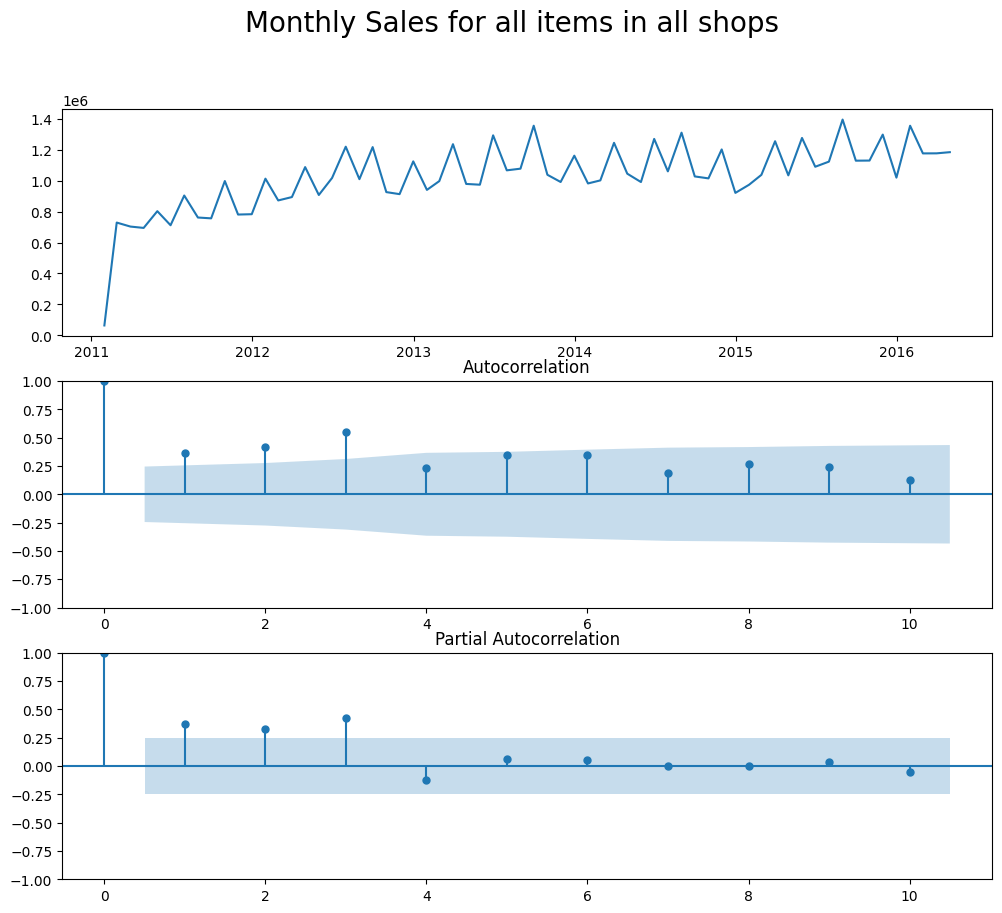

In [49]:
y = df_forecast.set_index("date").resample("M")["sales"].sum()
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

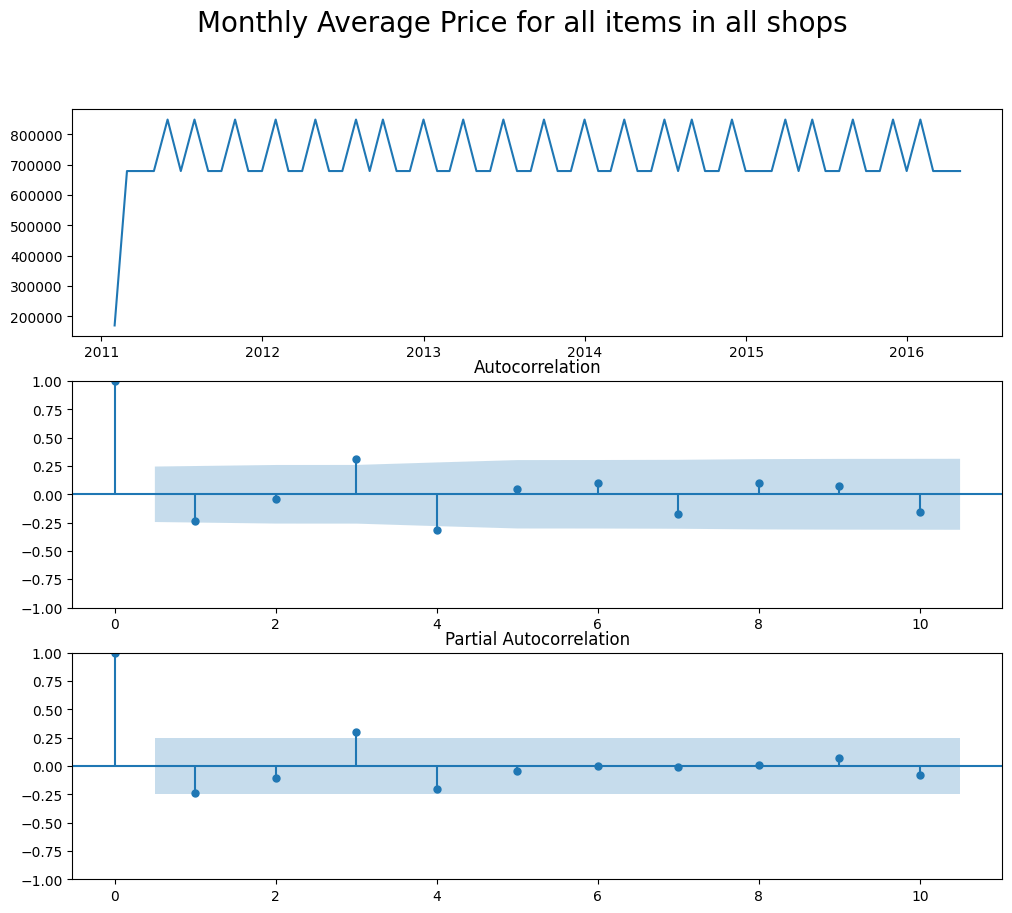

In [50]:
y = df_forecast.set_index("date").resample("M")["price"].sum()
plot_ts_acf_pacf(y = y, title = "Monthly Average Price for all items in all shops");

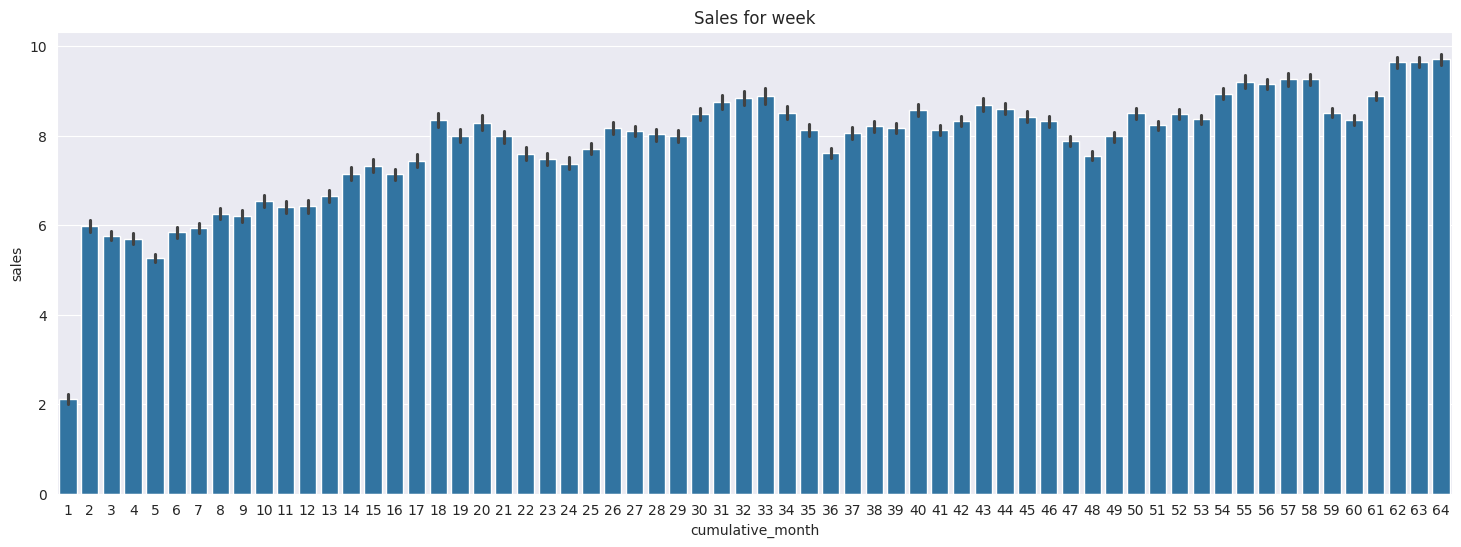

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,6))
plt.title('Sales for week')
sns.barplot(data=df_forecast, x='cumulative_month', y='sales')
plt.show()

<Axes: ylabel='sales'>

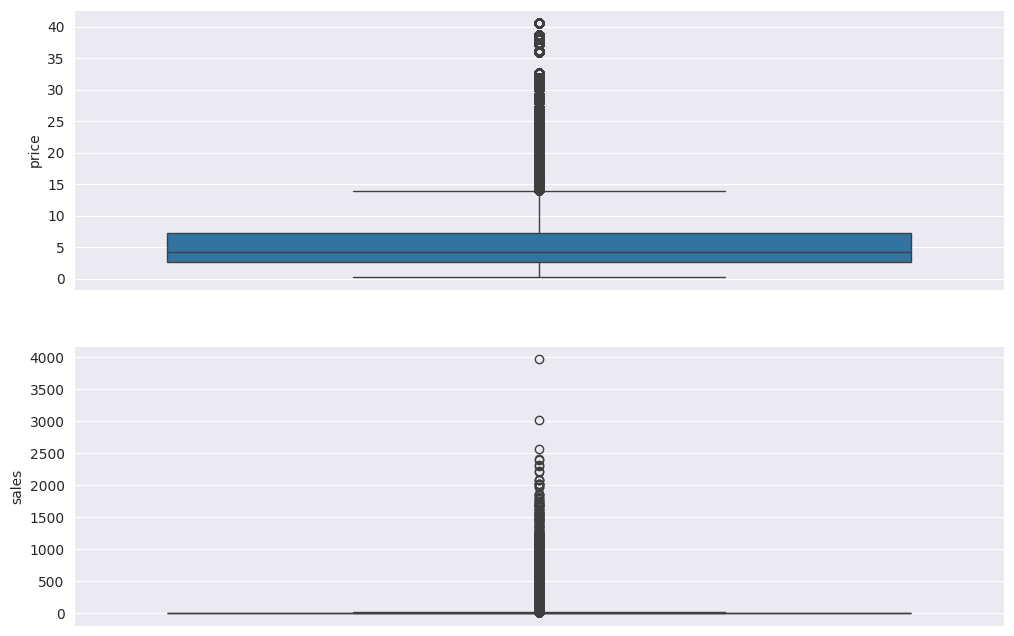

In [ ]:
#Se analiza la distribucion del precio por item y el numero de items vendidos por dia mediante diagramas de box.
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(df_forecast["price"], ax=ax[0])
sns.boxplot(df_forecast["sales"], ax=ax[1])

In [ ]:
(df_forecast[df_forecast["price"]>40])['id'].unique()

array(['ACCESORIES_1_060_NYC_1', 'ACCESORIES_1_225_NYC_1',
       'ACCESORIES_1_361_NYC_1', 'ACCESORIES_1_060_NYC_2',
       'ACCESORIES_1_225_NYC_2', 'ACCESORIES_1_361_NYC_2',
       'ACCESORIES_1_060_NYC_3', 'ACCESORIES_1_225_NYC_3',
       'ACCESORIES_1_361_NYC_3', 'ACCESORIES_1_060_NYC_4',
       'ACCESORIES_1_225_NYC_4', 'ACCESORIES_1_361_NYC_4',
       'ACCESORIES_1_060_PHI_1', 'ACCESORIES_1_225_PHI_1',
       'ACCESORIES_1_361_PHI_1', 'ACCESORIES_1_060_PHI_2',
       'ACCESORIES_1_225_PHI_2', 'ACCESORIES_1_361_PHI_2',
       'ACCESORIES_1_060_PHI_3', 'ACCESORIES_1_225_PHI_3',
       'ACCESORIES_1_361_PHI_3'], dtype=object)

In [ ]:
print(f'Min price: {df_forecast["price"].min()}, Max price: {df_forecast["price"].max()}')

Min price: 0.22799999999999998, Max price: 40.60720445544555


In [ ]:
(df_forecast[df_forecast["sales"]>2000])['id'].unique()

array(['SUPERMARKET_3_318_NYC_3', 'SUPERMARKET_3_090_NYC_3',
       'SUPERMARKET_3_090_BOS_2'], dtype=object)

In [ ]:
print(f'Min sale: {df_forecast["sales"].min()}, Max sale: {df_forecast["sales"].max()}')

Min sale: 0, Max sale: 3976
